In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('PJMW_hourly.csv',index_col=[0], parse_dates=[0])

# Exploratory Data Analysis

In [2]:
def date_time_extract(df, label = None):
    
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = date_time_extract(df, label = 'PJMW_MW')

df_new = pd.concat([X,y], axis = 1)

In [3]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

df_new['Season'] = df_new['month'].apply(month_to_season)


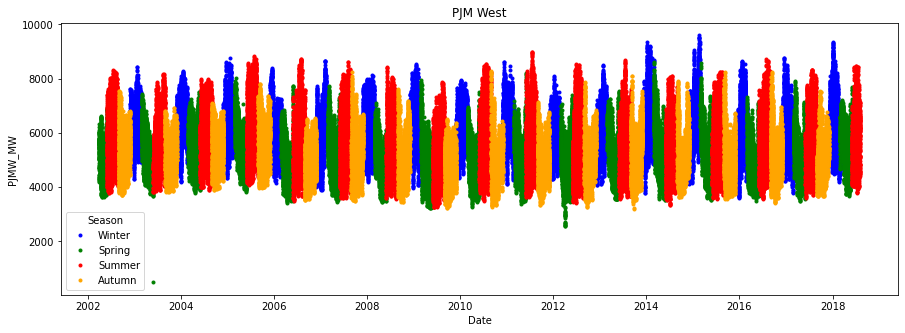

In [4]:
season_colours = {
    'Winter': 'blue',
    'Spring': 'green',
    'Summer': 'red',
    'Autumn': 'orange'
}

plt.figure(figsize=(15, 5))

for season, colour in season_colours.items():
    season_data = df_new[df_new['Season'] == season]
    plt.plot(season_data.index, season_data['PJMW_MW'], '.', label=season, color=colour)

plt.title('PJM West')
plt.xlabel('Date')
plt.ylabel('PJMW_MW')
plt.legend(title='Season')
plt.show()


- Noticable trend between the different seasons across the years

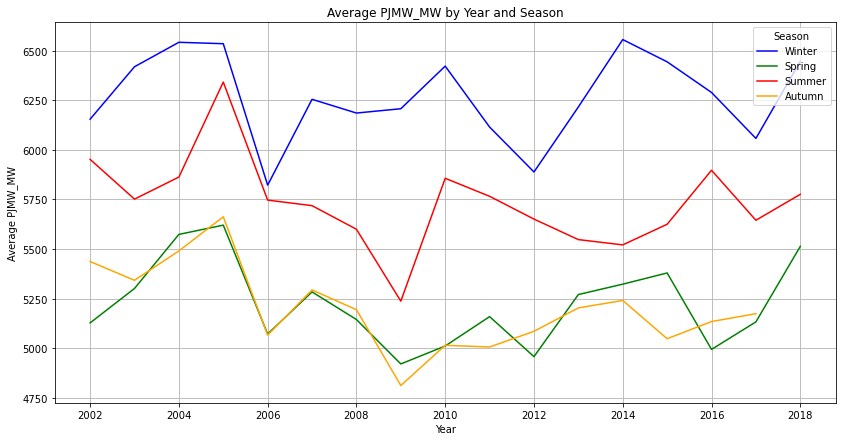

In [5]:
grouped = df_new.groupby(['year', 'Season'])['PJMW_MW'].mean().reset_index()

# Set the order of seasons to ensure proper sorting in the plot
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

plt.figure(figsize=(14, 7))
sns.lineplot(data=grouped, x='year', y='PJMW_MW', hue='Season', palette=season_colours, hue_order=season_order)

plt.title('Average PJMW_MW by Year and Season')
plt.xlabel('Year')
plt.ylabel('Average PJMW_MW')
plt.legend(title='Season')
plt.grid(True)
plt.show()

- On average, Winter consumes most power followed by Summer. Spring and Winter are relatively closer in power consumption

In [6]:
# Group by Season and Hour and calculate the mean of PJMW_MW
hourly_means = df_new.groupby(['Season', 'hour'])['PJMW_MW'].mean().reset_index()

# Find the hour with the highest average PJMW_MW for each season
max_hour_per_season = hourly_means.loc[hourly_means.groupby('Season')['PJMW_MW'].idxmax()]

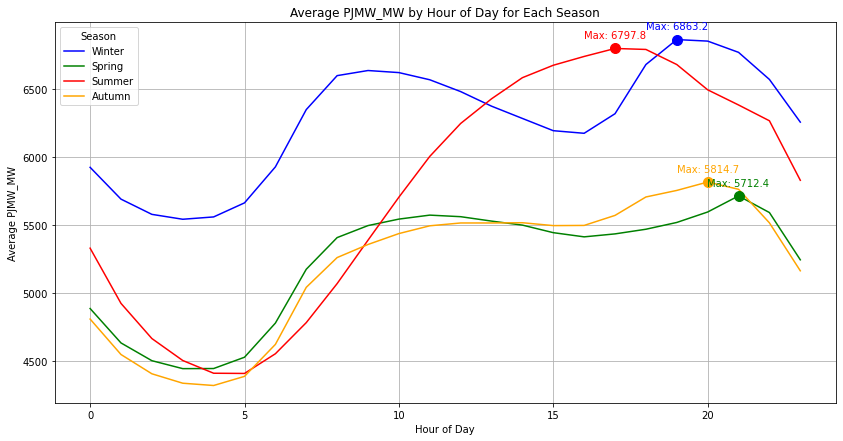

In [7]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=hourly_means, x='hour', y='PJMW_MW', hue='Season', palette=season_colours, hue_order=season_order)

for idx, row in max_hour_per_season.iterrows():
    plt.plot(row['hour'], row['PJMW_MW'], 'o', color=season_colours[row['Season']], markersize=10)
    plt.annotate(f'Max: {row["PJMW_MW"]:.1f}', 
                 (row['hour'], row['PJMW_MW']), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 color=season_colours[row['Season']])

plt.title('Average PJMW_MW by Hour of Day for Each Season')
plt.xlabel('Hour of Day')
plt.ylabel('Average PJMW_MW')
plt.legend(title='Season')
plt.grid(True)
plt.show()

- Different peaks of PWJW_MW across the day for different seasons. This can be explained by weather, routine and seasonal variations. 
- As expected slump in periods of inactivity (12am - 5am) and heightened consumption during periods of typical peaks of activity in morning (6am - 10pm) and in the evening (5pm - 9pm). 

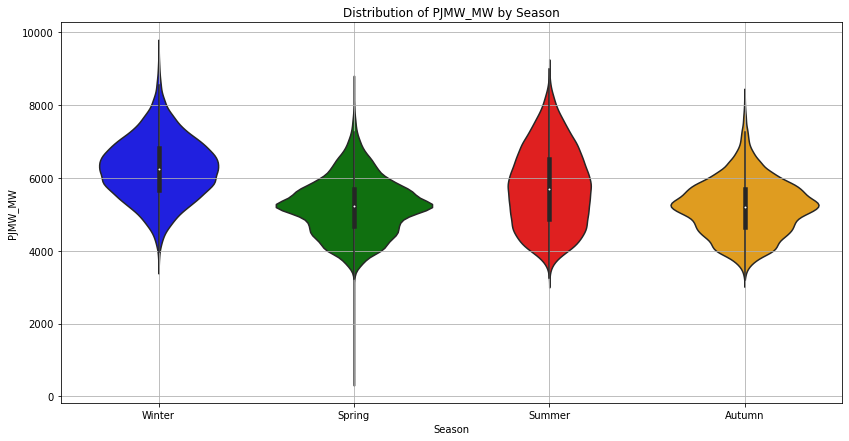

In [8]:
plt.figure(figsize=(14, 7))
sns.violinplot(x='Season', y='PJMW_MW', data=df_new, palette=season_colours, order=season_order)
plt.title('Distribution of PJMW_MW by Season')
plt.xlabel('Season')
plt.ylabel('PJMW_MW')
plt.grid(True)
plt.show()


- Spring and Autumn have sharper peaks in comparison to Winter and Summer distributions. 
- Indicates a more consistent power consumption rate across the day needed for Winter/Summer to mitigate against more extreme weather/seasonal conditions

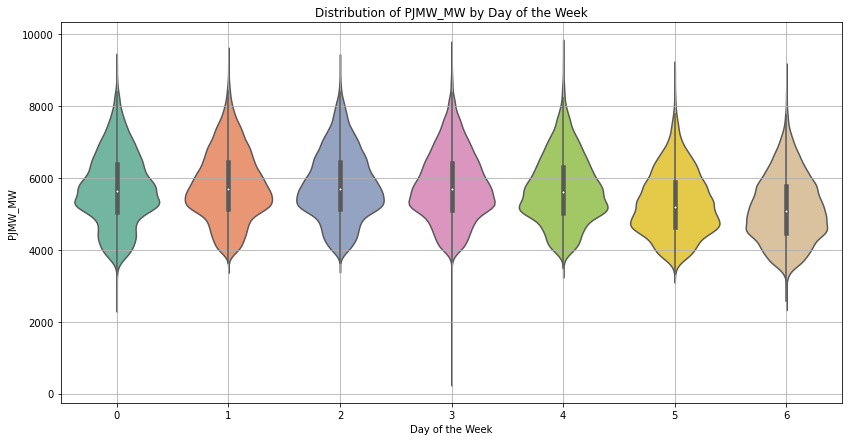

In [9]:
plt.figure(figsize=(14, 7))
sns.violinplot(x='dayofweek', y='PJMW_MW', data=df_new, palette='Set2')
plt.title('Distribution of PJMW_MW by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('PJMW_MW')
plt.grid(True)
plt.show()


- Clear similarity in distributions across weekdays. 
- Slightly more left skew distributions for weekends. 

In [10]:
outliers = df_new[df_new['PJMW_MW'] < 3150]

outliers

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJMW_MW,Season
Datetime,,,,,,,,,,
2003-05-29 00:00:00,0,3,2,5,2003,149,29,22,487.0,Spring
2012-04-01 01:00:00,1,6,2,4,2012,92,1,13,3002.0,Spring
2012-04-01 02:00:00,2,6,2,4,2012,92,1,13,2977.0,Spring
2012-04-01 03:00:00,3,6,2,4,2012,92,1,13,2992.0,Spring
2012-04-01 04:00:00,4,6,2,4,2012,92,1,13,3083.0,Spring
2012-04-01 05:00:00,5,6,2,4,2012,92,1,13,3110.0,Spring
2012-04-01 06:00:00,6,6,2,4,2012,92,1,13,2955.0,Spring
2012-04-01 07:00:00,7,6,2,4,2012,92,1,13,2942.0,Spring
2012-04-01 08:00:00,8,6,2,4,2012,92,1,13,2936.0,Spring


- 2012 April 1st had an unusually 'unpowerful' day. The only news on this day was the Kentucky vs Ohio NCAA Basketball Title Game (PJMW serves both Kentucky and Ohio) - https://www.npr.org/2012/04/01/149789526/kentucky-to-face-kansas-in-ncaa-title-game. Hard to imagine that would have an impact of power consumption in the region. 
- No significant news found for the 28th -29th of May 2003.
- Highly likely that these are faulty measurements and need to be removed.

# CatBoost - Time Series Analysis

In [11]:
label_encoder = LabelEncoder()
df_new['Season'] = label_encoder.fit_transform(df_new['Season'])

split_date = '01-Jan-2016'

df_train = df_new.loc[df.index <= split_date].copy()
df_test = df_new.loc[df.index > split_date].copy()

In [12]:
X_train = df_train.drop(columns=['PJMW_MW'])
y_train = df_train['PJMW_MW']
X_test = df_test.drop(columns=['PJMW_MW'])
y_test = df_test['PJMW_MW']

In [13]:
kf = KFold(n_splits=5, shuffle = False)

rmse_scores = []

In [14]:
# Cross-validation loop
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Create CatBoost model
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=0)
    
    # Train the model
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), cat_features=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Season'], early_stopping_rounds=50)
    
    # Make predictions
    y_val_pred = model.predict(X_val_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    rmse_scores.append(rmse)
    
# Calculate average RMSE across folds
average_rmse = np.mean(rmse_scores)
print(f'Average Cross-Val Fold RMSE: {average_rmse}')

# Train final model on the entire training set
final_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=0)
final_model.fit(X_train, y_train, cat_features=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Season'])

# Make predictions on the test set
y_test_pred = final_model.predict(X_test)

# Evaluate the final model on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: {test_rmse}')

df_test['CB_Prediction'] = final_model.predict(X_test)

df_final = pd.concat([df_test, df_train], sort= False)

Average Cross-Val Fold RMSE: 562.6274533218591
Test RMSE: 656.4787794392425


# Evaluation

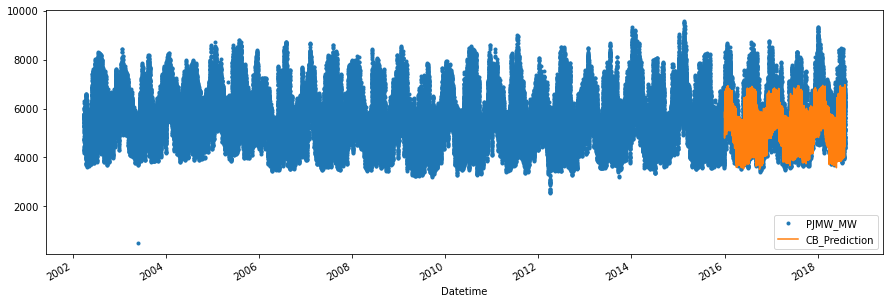

In [15]:
_ = df_final[['PJMW_MW','CB_Prediction']].plot(figsize=(15, 5), style=['.'])

- From top level view, CB_Prediction tends towards the mean, does not predict PMJW_MW values over 7000. 

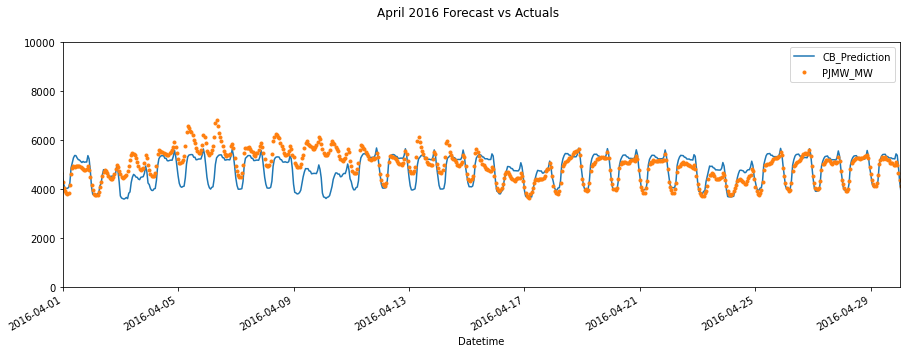

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_final[['CB_Prediction','PJMW_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='04-01-2016', upper='04-30-2016')
ax.set_ylim(0, 10000)
plot = plt.suptitle('April 2016 Forecast vs Actuals')

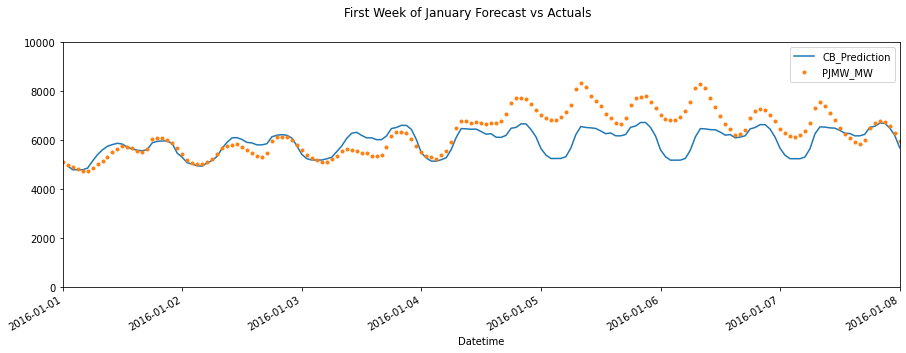

In [17]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_final[['CB_Prediction','PJMW_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2016', upper='01-08-2016')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

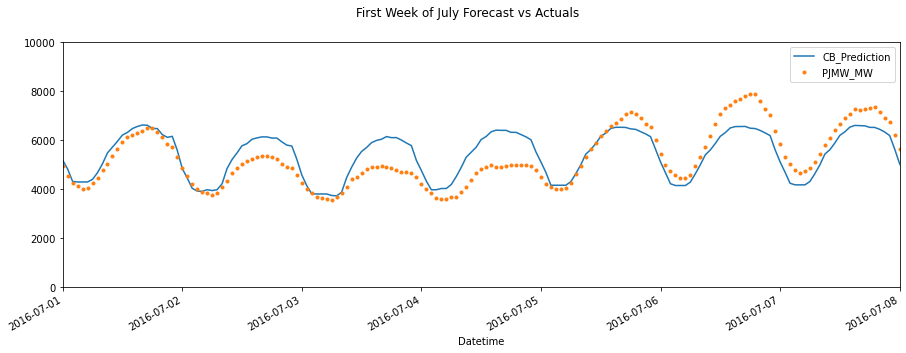

In [18]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_final[['CB_Prediction','PJMW_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 10000)
ax.set_xbound(lower='07-01-2016', upper='07-08-2016')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

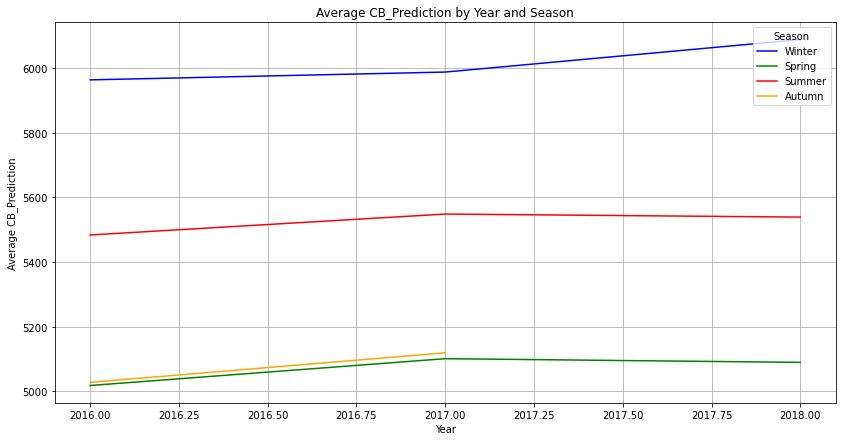

In [19]:
grouped = df_final.groupby(['year', 'Season'])['CB_Prediction'].mean().reset_index()

season_mapping = {
    3: 'Winter',
    0: 'Autumn',
    1: 'Spring',
    2: 'Summer'
}

grouped['Season'] = grouped['Season'].map(season_mapping)

# Set the order of seasons to ensure proper sorting in the plot
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

plt.figure(figsize=(14, 7))
sns.lineplot(data=grouped, x='year', y='CB_Prediction', hue='Season', palette=season_colours, hue_order=season_order)

plt.title('Average CB_Prediction by Year and Season')
plt.xlabel('Year')
plt.ylabel('Average CB_Prediction')
plt.legend(title='Season')
plt.grid(True)
plt.show()

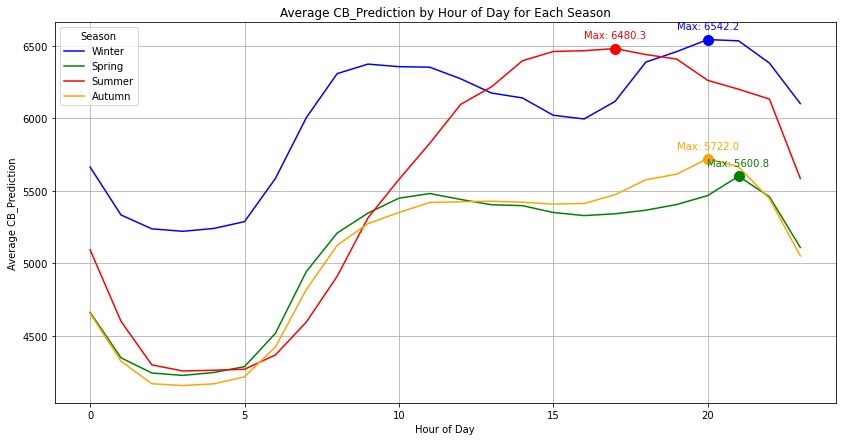

In [20]:
# Group by Season and Hour and calculate the mean of PJMW_MW
hourly_means = df_final.groupby(['Season', 'hour'])['CB_Prediction'].mean().reset_index()

season_mapping = {
    3: 'Winter',
    0: 'Autumn',
    1: 'Spring',
    2: 'Summer'
}

hourly_means['Season'] = hourly_means['Season'].map(season_mapping)

max_hour_per_season = hourly_means.loc[hourly_means.groupby('Season')['CB_Prediction'].idxmax()]

plt.figure(figsize=(14, 7))
sns.lineplot(data=hourly_means, x='hour', y='CB_Prediction', hue='Season', palette=season_colours, hue_order=season_order)

for idx, row in max_hour_per_season.iterrows():
    plt.plot(row['hour'], row['CB_Prediction'], 'o', color=season_colours[row['Season']], markersize=10)
    plt.annotate(f'Max: {row["CB_Prediction"]:.1f}', 
                 (row['hour'], row['CB_Prediction']), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 color=season_colours[row['Season']])

plt.title('Average CB_Prediction by Hour of Day for Each Season')
plt.xlabel('Hour of Day')
plt.ylabel('Average CB_Prediction')
plt.legend(title='Season')
plt.grid(True)
plt.show()

- CB_Prediction trends are similar to PMJW_MW trends across 'Hours of Day' and Season across tested Years. 

# Error

In [21]:
mean_squared_error = mean_squared_error(y_true=df_test['PJMW_MW'],
                   y_pred=df_test['CB_Prediction'])

mean_absolute_error = mean_absolute_error(y_true=df_test['PJMW_MW'],
                   y_pred=df_test['CB_Prediction'])

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error = mean_absolute_percentage_error(y_true=df_test['PJMW_MW'],
                   y_pred=df_test['CB_Prediction'])

print(f'mean_squared_error: {mean_squared_error}')
print(f'mean_absolute_error: {mean_absolute_error}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error}')

mean_squared_error: 430964.38785403763
mean_absolute_error: 486.3805609528418
mean_absolute_percentage_error: 8.235561851349173


In [22]:
df_test['error'] = df_test['PJMW_MW'] - df_test['CB_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth','dayofweek']) \
    .mean()[['PJMW_MW','CB_Prediction','error','abs_error']]

# Over forecasted
error_by_day.sort_values('error', ascending=True).head(25)

PJMW_MW  CB_Prediction        error  \
year month dayofmonth dayofweek                                            
2017 2     24         4          4780.625000    6131.855914 -1351.230914   
2018 2     21         2          5044.958333    6256.340379 -1211.382046   
2017 2     19         6          4587.875000    5793.813052 -1205.938052   
           23         3          4978.458333    6163.564979 -1185.106646   
           25         5          4588.791667    5764.859398 -1176.067731   
2018 2     15         3          5301.000000    6343.237609 -1042.237609   
2017 2     20         0          5087.208333    6120.348074 -1033.139741   
           8          2          5224.416667    6234.994657 -1010.577991   
           22         2          5166.416667    6150.973215  -984.556549   
2016 7     4          0          4429.541667    5392.879450  -963.337783   
2018 2     20         1          5247.708333    6152.166592  -904.458259   
2016 12    27         1          5062.583333    5929.867447  -867.284113   
2017 1     22         6          4918.875000    5786.119222  -867.244222   
2018 2     16         4          5387.583333    6246.043202  -858.459868   
2016 3     11         4          4738.333333    5594.712899  -856.379566   
2017 2     7          1          5386.541667    6238.451971  -851.910304   
           21         1          5337.208333    6186.814060  -849.605726   
2018 2     26         0          5491.833333    6338.761309  -846.927976   
     1     12         4          5243.791667    6072.169490  -828.377824   
2017 2     28         1          5469.708333    6297.497608  -827.789274   
2016 3     25         4          4617.333333    5433.168707  -815.835373   
     12    26         0          5141.125000    5956.586305  -815.461305   
     2     29         0          5379.833333    6191.095327  -811.261994   
2018 2     28         2          5555.833333    6360.402783  -804.569450   
           22         3          5483.041667    6277.487191  -794.445524   

                                   abs_error  
year month dayofmonth dayofweek               
2017 2     24         4          1351.230914  
2018 2     21         2          1211.382046  
2017 2     19         6          1205.938052  
           23         3          1185.106646  
           25         5          1176.067731  
2018 2     15         3          1042.237609  
2017 2     20         0          1033.139741  
           8          2          1010.577991  
           22         2           984.556549  
2016 7     4          0           963.337783  
2018 2     20         1           904.458259  
2016 12    27         1           867.284113  
2017 1     22         6           867.244222  
2018 2     16         4           858.459868  
2016 3     11         4           856.379566  
2017 2     7          1           851.910304  
           21         1           849.605726  
2018 2     26         0           846.927976  
     1     12         4           828.377824  
2017 2     28         1           827.789274  
2016 3     25         4           815.835373  
     12    26         0           815.461305  
     2     29         0           811.261994  
2018 2     28         2           804.569450  
           22         3           794.445524

- A significant portion of over forecasted errors come from February. This could be because there is a significant difference between PMMW_MW consumed from Winter to Spring, where often weather conditions and seasonal changes across the years may vary. 
- A few public holidays or days surrounding public holidays, 19th Feb (Washington's Birthday), July 5th (Independence Day) and Dec 26th & 27th (Post Christmas Day)

In [23]:
# Underforecasted
error_by_day.sort_values('error', ascending=False).head(25)

PJMW_MW  CB_Prediction        error  \
year month dayofmonth dayofweek                                            
2018 1     6          5          8579.375000    5618.944102  2960.430898   
           5          4          8794.583333    6017.110203  2777.473130   
           7          6          8067.041667    5513.566075  2553.475592   
2017 1     8          6          7658.500000    5586.300135  2072.199865   
2018 1     3          2          8077.000000    6046.244115  2030.755885   
           2          1          8044.833333    6024.454800  2020.378533   
2016 12    16         4          7881.125000    5871.629526  2009.495474   
2018 1     4          3          8076.500000    6075.341780  2001.158220   
           1          0          7735.166667    5774.093474  1961.073193   
2017 12    31         6          7500.125000    5564.326885  1935.798115   
     1     9          0          7820.333333    6028.443083  1791.890251   
     12    28         3          7774.791667    5995.756992  1779.034675   
2016 2     14         6          7491.791667    5714.223639  1777.568028   
2018 1     14         6          7329.541667    5592.790702  1736.750964   
2017 1     7          5          7358.166667    5642.399275  1715.767392   
2016 1     19         1          8016.666667    6311.211272  1705.455395   
2017 3     15         2          7282.916667    5602.836261  1680.080405   
2016 12    15         3          7656.666667    5993.147298  1663.519369   
     2     13         5          7474.833333    5826.119647  1648.713686   
2018 1     15         0          7776.750000    6172.334431  1604.415569   
2016 8     13         5          6844.500000    5247.372721  1597.127279   
2018 1     17         2          7731.791667    6176.966608  1554.825058   
2017 12    29         4          7495.333333    5944.560722  1550.772611   
2016 1     20         2          7758.208333    6243.403790  1514.804543   
     8     12         4          7132.541667    5622.461805  1510.079862   

                                   abs_error  
year month dayofmonth dayofweek               
2018 1     6          5          2960.430898  
           5          4          2777.473130  
           7          6          2553.475592  
2017 1     8          6          2072.199865  
2018 1     3          2          2030.755885  
           2          1          2020.378533  
2016 12    16         4          2009.495474  
2018 1     4          3          2001.158220  
           1          0          1961.073193  
2017 12    31         6          1935.798115  
     1     9          0          1791.890251  
     12    28         3          1779.034675  
2016 2     14         6          1777.568028  
2018 1     14         6          1736.750964  
2017 1     7          5          1715.767392  
2016 1     19         1          1705.455395  
2017 3     15         2          1680.080405  
2016 12    15         3          1663.519369  
     2     13         5          1648.713686  
2018 1     15         0          1604.415569  
2016 8     13         5          1597.127279  
2018 1     17         2          1554.825058  
2017 12    29         4          1550.772611  
2016 1     20         2          1514.804543  
     8     12         4          1510.079862

- As evidenced in the initial PMMW_MW vs CB_Prediction plot, the higher the power consumption, the lesser likely the model tends to under forecast and predicts closer to mean. As seen by the above errors being predominantly from Winter. 
- Perhaps a winter indicator needs to be include an multiplier or indicator for Winter. 

In [27]:
# Best predicted days

error_by_day.sort_values('abs_error', ascending=True).head(10)

PJMW_MW  CB_Prediction      error  \
year month dayofmonth dayofweek                                          
2017 9     15         4          5192.958333    5200.791383  -7.833050   
2018 8     3          4          5489.000000    5431.855992  57.144008   
2017 5     22         0          4960.208333    4963.818152  -3.609819   
     1     29         6          5806.541667    5756.550156  49.991510   
2016 10    22         5          4616.875000    4593.366807  23.508193   
     5     12         3          4935.458333    4969.678630 -34.220297   
2017 2     1          2          6155.791667    6114.263062  41.528605   
     5     21         6          4546.458333    4484.487648  61.970685   
2016 4     28         3          4890.250000    4918.349087 -28.099087   
2018 4     24         1          5100.375000    5108.585132  -8.210132   

                                 abs_error  
year month dayofmonth dayofweek             
2017 9     15         4          55.171894  
2018 8     3          4          57.144008  
2017 5     22         0          64.379172  
     1     29         6          65.466313  
2016 10    22         5          68.673514  
     5     12         3          70.298461  
2017 2     1          2          74.536912  
     5     21         6          77.579127  
2016 4     28         3          79.268490  
2018 4     24         1          83.569697

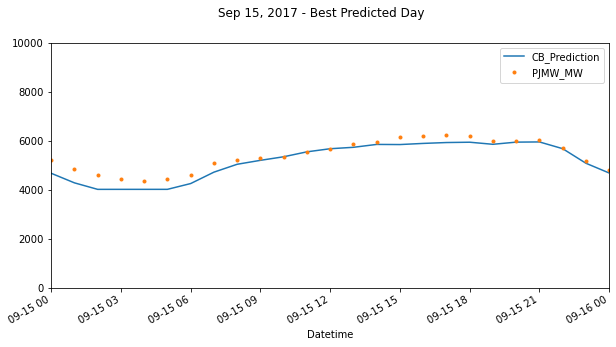

In [32]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_final[['CB_Prediction','PJMW_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 10000)
ax.set_xbound(lower='09-15-2016', upper='09-16-2016')
plot = plt.suptitle('Sep 15, 2017 - Best Predicted Day')

In [28]:
# Worst predicted days

error_by_day.sort_values('abs_error', ascending=False).head(10)

PJMW_MW  CB_Prediction        error  \
year month dayofmonth dayofweek                                            
2018 1     6          5          8579.375000    5618.944102  2960.430898   
           5          4          8794.583333    6017.110203  2777.473130   
           7          6          8067.041667    5513.566075  2553.475592   
2017 1     8          6          7658.500000    5586.300135  2072.199865   
2018 1     3          2          8077.000000    6046.244115  2030.755885   
           2          1          8044.833333    6024.454800  2020.378533   
2016 12    16         4          7881.125000    5871.629526  2009.495474   
2018 1     4          3          8076.500000    6075.341780  2001.158220   
           1          0          7735.166667    5774.093474  1961.073193   
2017 12    31         6          7500.125000    5564.326885  1935.798115   

                                   abs_error  
year month dayofmonth dayofweek               
2018 1     6          5          2960.430898  
           5          4          2777.473130  
           7          6          2553.475592  
2017 1     8          6          2072.199865  
2018 1     3          2          2030.755885  
           2          1          2020.378533  
2016 12    16         4          2009.495474  
2018 1     4          3          2001.158220  
           1          0          1961.073193  
2017 12    31         6          1935.798115

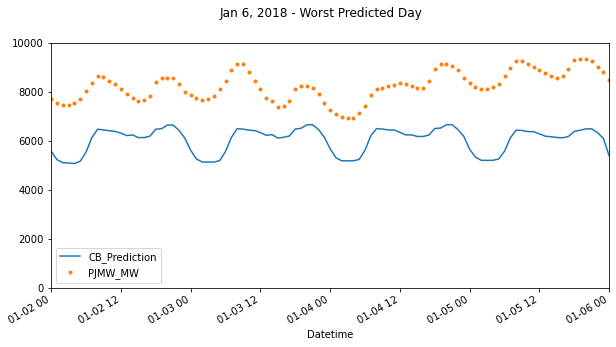

In [33]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_final[['CB_Prediction','PJMW_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 10000)
ax.set_xbound(lower='01-06-2018', upper='01-02-2018')
plot = plt.suptitle('Jan 6, 2018 - Worst Predicted Day')